In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split

## Load Datasets

In [2]:
# main train and test datasets
columns = ['user_id', 'item_id', 'rating', 'timestamp']
train_df = pd.read_csv('data/ua.train', sep='\t', names=columns)
test_df = pd.read_csv('data/ua.test', sep='\t', names=columns)

# item information
item_columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url'] + [f'genre_{i}' for i in range(19)]
items_df = pd.read_csv('data/u.item', sep='|', names=item_columns, encoding='latin-1')

# genre names for readability
genres_df = pd.read_csv('data/u.genre', sep='|', names=['genre', 'genre_id'])
genre_mapping = dict(zip(genres_df['genre_id'], genres_df['genre']))

for i in range(len(genres_df)):
    old_name = f'genre_{i}'
    new_name = genre_mapping[i]
    items_df = items_df.rename(columns={old_name: new_name})
    
    
# user information
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_df = pd.read_csv('data/u.user', sep='|', names=user_columns)

# combine dataframes
train_df = train_df.merge(items_df, left_on='item_id', right_on='movie_id')
train_df = train_df.merge(users_df, on='user_id')

test_df = test_df.merge(items_df, left_on='item_id', right_on='movie_id')
test_df = test_df.merge(users_df, on='user_id')

In [3]:
train_df.head()

,user_id,item_id,rating,timestamp,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code
0,1,1,5,874965758,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,...,0,0,0,0,0,0,24,M,technician,85711
1,1,2,3,876893171,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,...,0,0,0,1,0,0,24,M,technician,85711
2,1,3,4,878542960,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,...,0,0,0,1,0,0,24,M,technician,85711
3,1,4,3,876893119,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,...,0,0,0,0,0,0,24,M,technician,85711
4,1,5,3,889751712,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,...,0,0,0,1,0,0,24,M,technician,85711


In [4]:
train_df.columns

Index(['user_id', 'item_id', 'rating', 'timestamp', 'movie_id', 'movie_title',
       'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action',
       'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
       'gender', 'occupation', 'zip_code'],
      dtype='object')

In [5]:
print(train_df.shape)
print(test_df.shape)

(90570, 32)
(9430, 32)


## EDA

### Check for null values

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90570 entries, 0 to 90569
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             90570 non-null  int64  
 1   item_id             90570 non-null  int64  
 2   rating              90570 non-null  int64  
 3   timestamp           90570 non-null  int64  
 4   movie_id            90570 non-null  int64  
 5   movie_title         90570 non-null  object 
 6   release_date        90562 non-null  object 
 7   video_release_date  0 non-null      float64
 8   imdb_url            90558 non-null  object 
 9   unknown             90570 non-null  int64  
 10  Action              90570 non-null  int64  
 11  Adventure           90570 non-null  int64  
 12  Animation           90570 non-null  int64  
 13  Children's          90570 non-null  int64  
 14  Comedy              90570 non-null  int64  
 15  Crime               90570 non-null  int64  
 16  Docu

Only _video_release_date_ has null values, and we can remove them since there is another _release_date_ column, which should be the same thing.

In [7]:
print('Unique Users:', train_df['user_id'].nunique())
print('Unique Movies:', train_df['item_id'].nunique())

Unique Users: 943
Unique Movies: 1680


There are 943 users and the average user has rated 90570/943 = ~96 movies in _train_df_.\
There are 1680 unique movies in _train_df_.

### Rating, Age, Gender & Occupation distributions

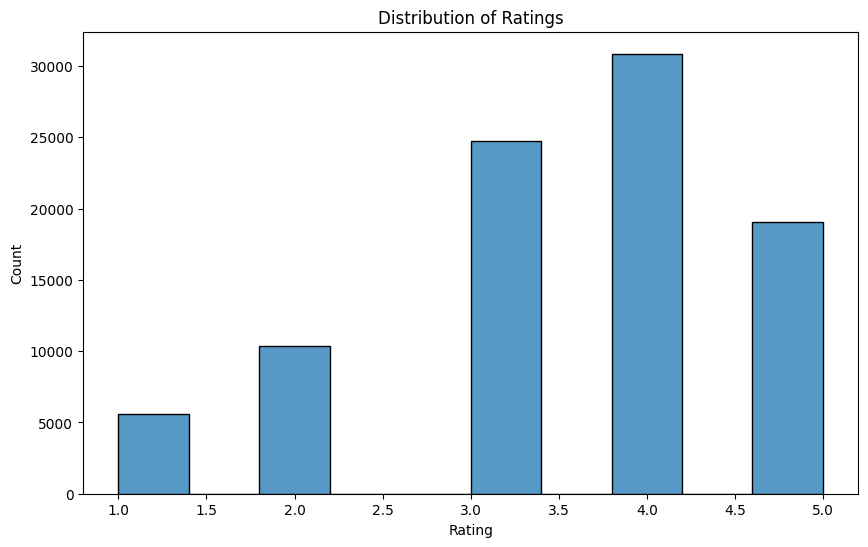

Rating Statistics:
count    90570.000000
mean         3.523827
std          1.126073
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64


In [8]:
# ratings (target variable)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['rating'], bins=10)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

print("Rating Statistics:")
print(train_df['rating'].describe())

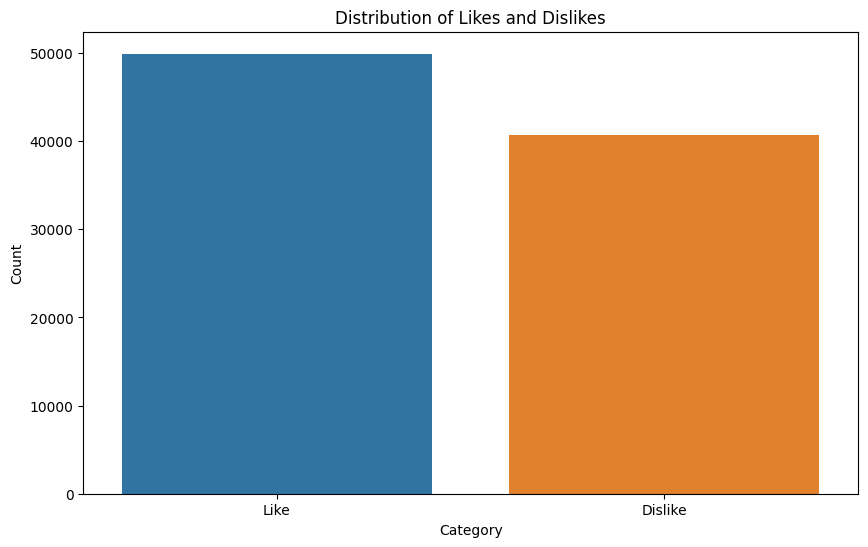

Like/Dislike Distribution:
like_dislike
Like       49906
Dislike    40664
Name: count, dtype: int64
Percentage of Likes: 55.10%
Percentage of Dislikes: 44.90%


In [9]:
# like & dislike (binary target variable)
train_df['like_dislike'] = train_df['rating'].apply(lambda x: 'Like' if x >= 4 else 'Dislike') 
test_df['like_dislike'] = test_df['rating'].apply(lambda x: 'Like' if x >= 4 else 'Dislike') 
plt.figure(figsize=(10, 6))
sns.countplot(x='like_dislike', data=train_df)
plt.title('Distribution of Likes and Dislikes')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

like_dislike_counts = train_df['like_dislike'].value_counts()
print("Like/Dislike Distribution:")
print(like_dislike_counts)
print(f"Percentage of Likes: {like_dislike_counts['Like'] / len(train_df) * 100:.2f}%")
print(f"Percentage of Dislikes: {like_dislike_counts['Dislike'] / len(train_df) * 100:.2f}%")

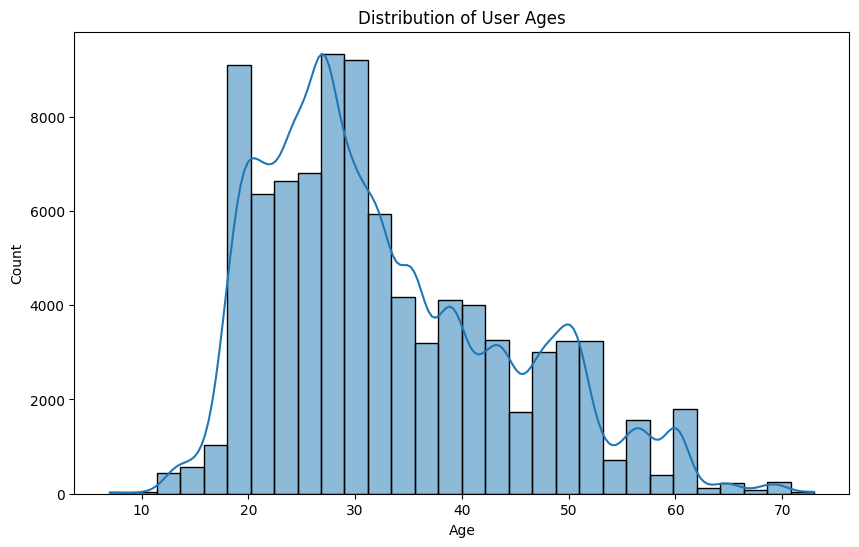

Age Statistics:
count    90570.000000
mean        32.857182
std         11.489888
min          7.000000
25%         24.000000
50%         30.000000
75%         40.000000
max         73.000000
Name: age, dtype: float64


In [10]:
# age distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['age'], kde=True, bins=30)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print("Age Statistics:")
print(train_df['age'].describe())

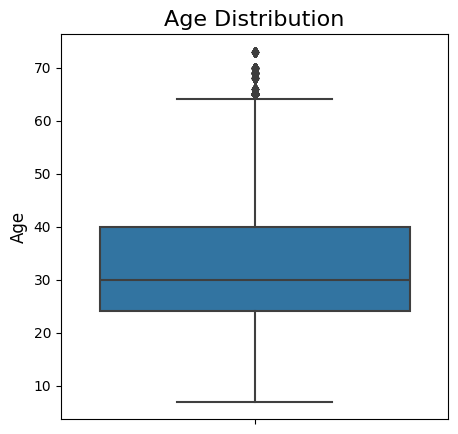

In [11]:
plt.figure(figsize=(5, 5))
sns.boxplot(y=train_df['age'])
plt.title('Age Distribution', fontsize=16)
plt.ylabel('Age', fontsize=12)
plt.show()

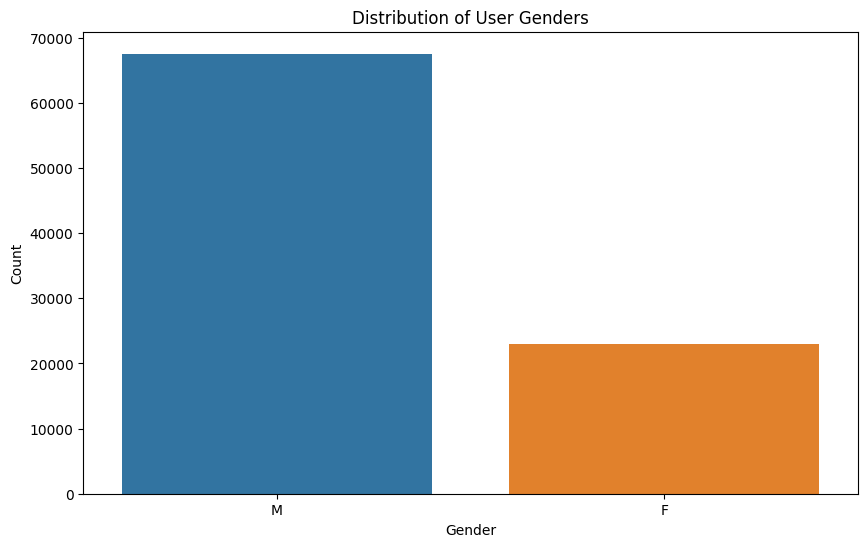


Gender Distribution:
gender
M    67560
F    23010
Name: count, dtype: int64


In [12]:
# gender distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', data=train_df)
plt.title('Distribution of User Genders')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

gender_counts = train_df['gender'].value_counts()
print("\nGender Distribution:")
print(gender_counts)

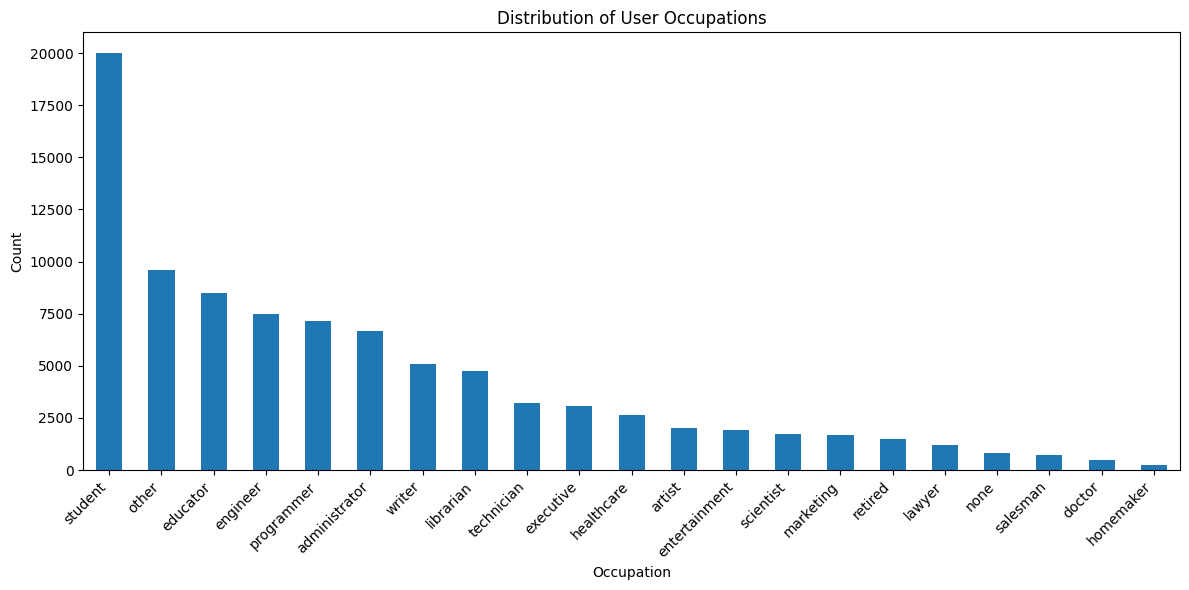

Top 5 Occupations:
occupation
student       19997
other          9613
educator       8492
engineer       7505
programmer     7141
Name: count, dtype: int64


In [13]:
# Occupation distribution
occupation_counts = train_df['occupation'].value_counts()
plt.figure(figsize=(12, 6))
occupation_counts.plot(kind='bar')
plt.title('Distribution of User Occupations')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Top 5 Occupations:")
print(occupation_counts.head())

### Additional Analysis of Rating, Age, Gender & Occupation

In [14]:
def plot_stacked_bars(data, x, y, title, xlabel, ylabel):
    # calculate counts and percentages
    counts = data.groupby(x)[y].value_counts().unstack()
    percentages = counts.div(counts.sum(axis=1), axis=0)
    
    ax = counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=[color_map['Dislike'], color_map['Like']])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # add percentage labels
    for c in ax.containers:
        labels = [f'{v.get_height():.0f}\n({p:.1%})' if v.get_height() > 0 else '' for v, p in zip(c, percentages[c.get_label()])]
        ax.bar_label(c, labels=labels, label_type='center')
    
    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()
    
    return counts, percentages

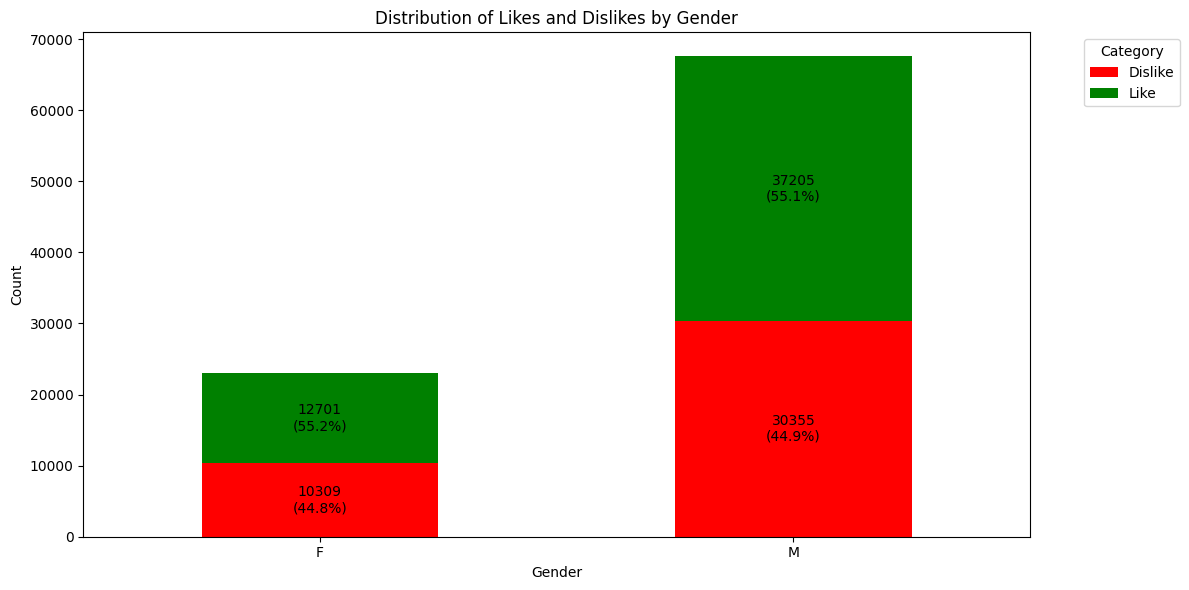

Like/Dislike Distribution by Gender:
like_dislike  Dislike   Like
gender                      
F               10309  12701
M               30355  37205

Percentages:
like_dislike   Dislike      Like
gender                          
F             0.448023  0.551977
M             0.449304  0.550696


In [15]:
color_map = {'Like': 'green', 'Dislike': 'red'}

# rating distribution by gender
gender_counts, gender_percentages = plot_stacked_bars(train_df, 'gender', 'like_dislike', 
                                                      'Distribution of Likes and Dislikes by Gender', 'Gender', 'Count')
print("Like/Dislike Distribution by Gender:")
print(gender_counts)
print("\nPercentages:")
print(gender_percentages)

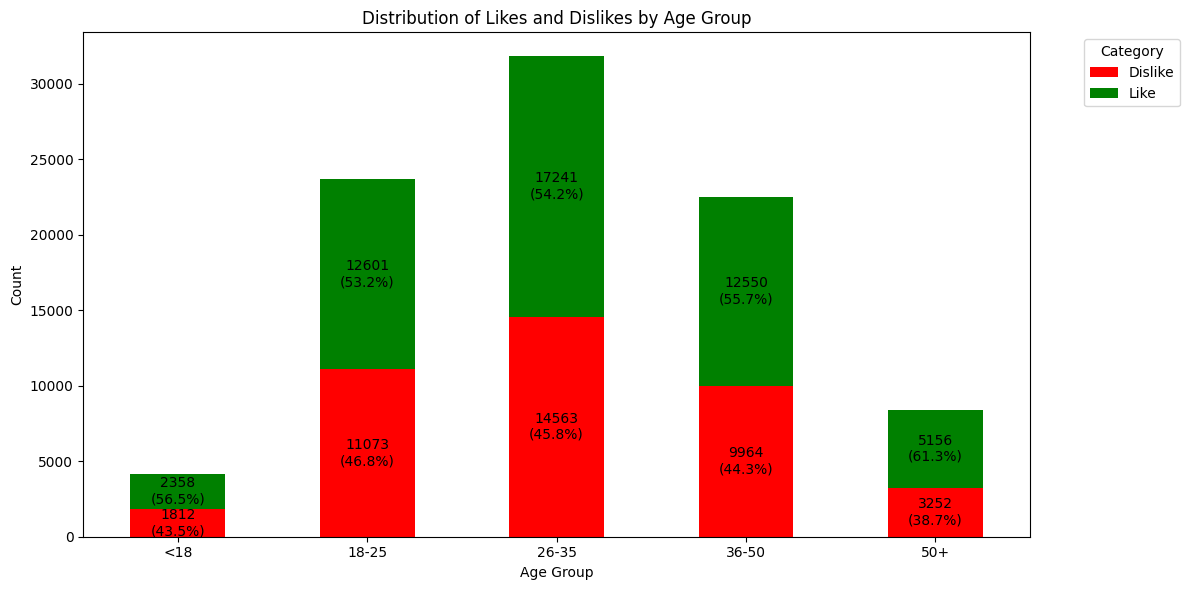

Like/Dislike Distribution by Age Group:
like_dislike  Dislike   Like
age_group                   
<18              1812   2358
18-25           11073  12601
26-35           14563  17241
36-50            9964  12550
50+              3252   5156

Percentages:
like_dislike   Dislike      Like
age_group                       
<18           0.434532  0.565468
18-25         0.467728  0.532272
26-35         0.457898  0.542102
36-50         0.442569  0.557431
50+           0.386775  0.613225


In [16]:
# rating distribution by age group
train_df['age_group'] = pd.cut(train_df['age'], bins=[0, 18, 25, 35, 50, 100], labels=['<18', '18-25', '26-35', '36-50', '50+'])
test_df['age_group'] = pd.cut(test_df['age'], bins=[0, 18, 25, 35, 50, 100], labels=['<18', '18-25', '26-35', '36-50', '50+'])
age_counts, age_percentages = plot_stacked_bars(train_df, 'age_group', 'like_dislike', 
                                                'Distribution of Likes and Dislikes by Age Group', 'Age Group', 'Count')
print("Like/Dislike Distribution by Age Group:")
print(age_counts)
print("\nPercentages:")
print(age_percentages)

### Temporal features analysis (timestamp, release date)

In [17]:
# convert timestamp to datetime
train_df['rating_date'] = pd.to_datetime(train_df['timestamp'], unit='s')

# convert release date to datetime
train_df['release_date'] = pd.to_datetime(train_df['release_date'], format='%d-%b-%Y', errors='coerce')

# extract date components
train_df['rating_month'] = train_df['rating_date'].dt.month
train_df['rating_day'] = train_df['rating_date'].dt.day_name()
train_df['release_year'] = train_df['release_date'].dt.year
train_df['release_month'] = train_df['release_date'].dt.month
train_df['release_day'] = train_df['release_date'].dt.day_name()
train_df['movie_age'] = (train_df['rating_date'] - train_df['release_date']).dt.days

# convert timestamp to datetime
test_df['rating_date'] = pd.to_datetime(test_df['timestamp'], unit='s')

# convert release date to datetime
test_df['release_date'] = pd.to_datetime(test_df['release_date'], format='%d-%b-%Y', errors='coerce')

# extract date components
test_df['rating_month'] = test_df['rating_date'].dt.month
test_df['rating_day'] = test_df['rating_date'].dt.day_name()
test_df['release_year'] = test_df['release_date'].dt.year
test_df['release_month'] = test_df['release_date'].dt.month
test_df['release_day'] = test_df['release_date'].dt.day_name()
test_df['movie_age'] = (test_df['rating_date'] - test_df['release_date']).dt.days

In [18]:
# plot count distributions
def plot_count_distribution(data, column, title, xlabel, ylabel="Count", order=None):
    plt.figure(figsize=(12, 6))
    if order is None:
        order = sorted(data[column].unique())
    sns.countplot(data=data, x=column, order=order)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### Rating timestamp

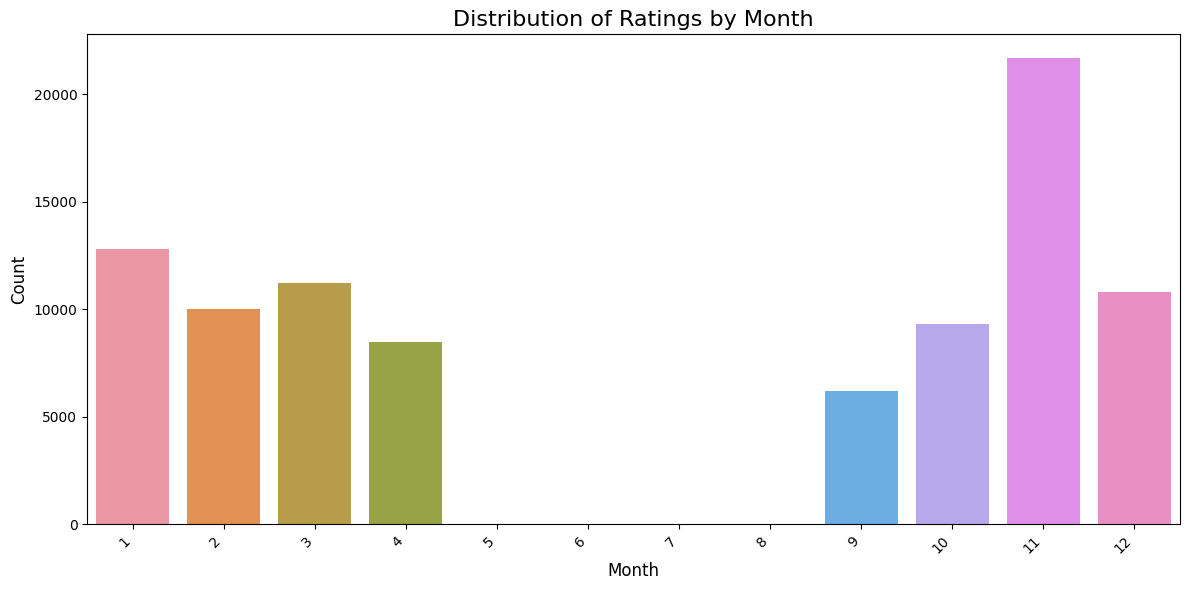

In [19]:
# distribution of ratings by month
months_order = range(1, 13)
plot_count_distribution(train_df, 'rating_month', 'Distribution of Ratings by Month', 'Month', order=months_order)

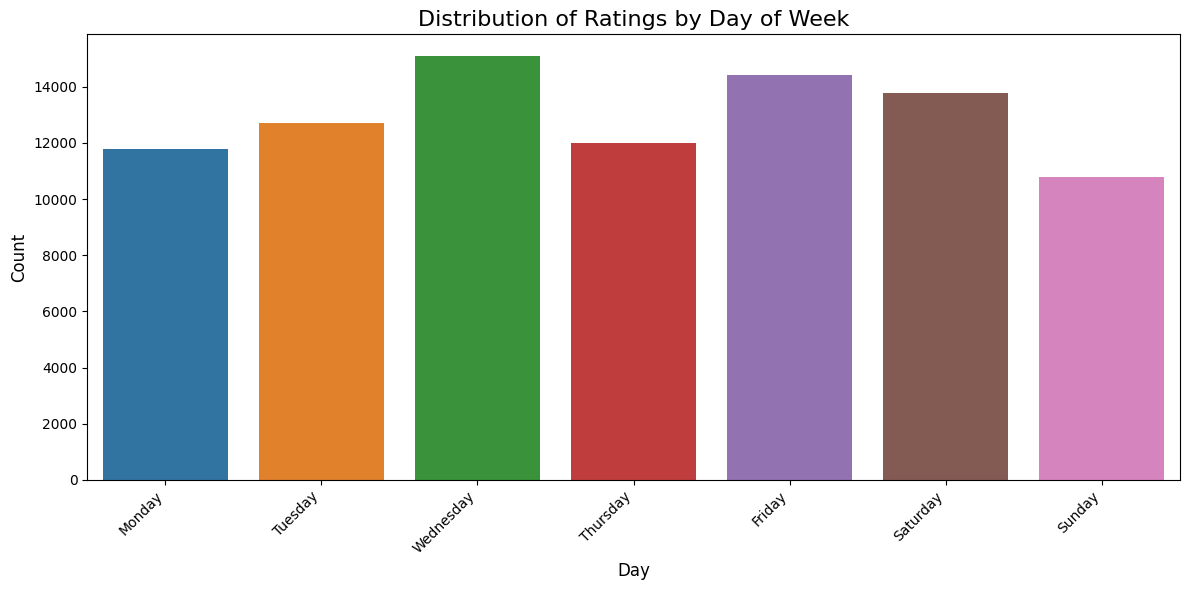

In [20]:
# distribution of ratings by day of week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot_count_distribution(train_df, 'rating_day', 'Distribution of Ratings by Day of Week', 'Day', order=days_order)

#### Movie date release

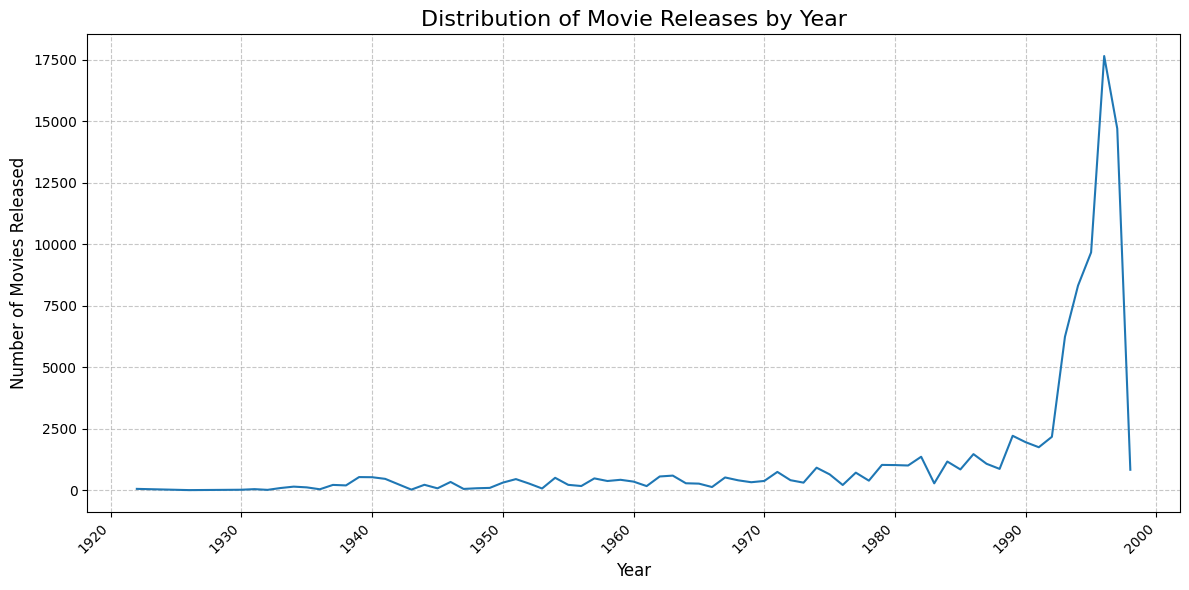

In [21]:
# distribution by release year
release_year_counts = train_df['release_year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.plot(release_year_counts.index, release_year_counts.values)
plt.title('Distribution of Movie Releases by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Movies Released', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

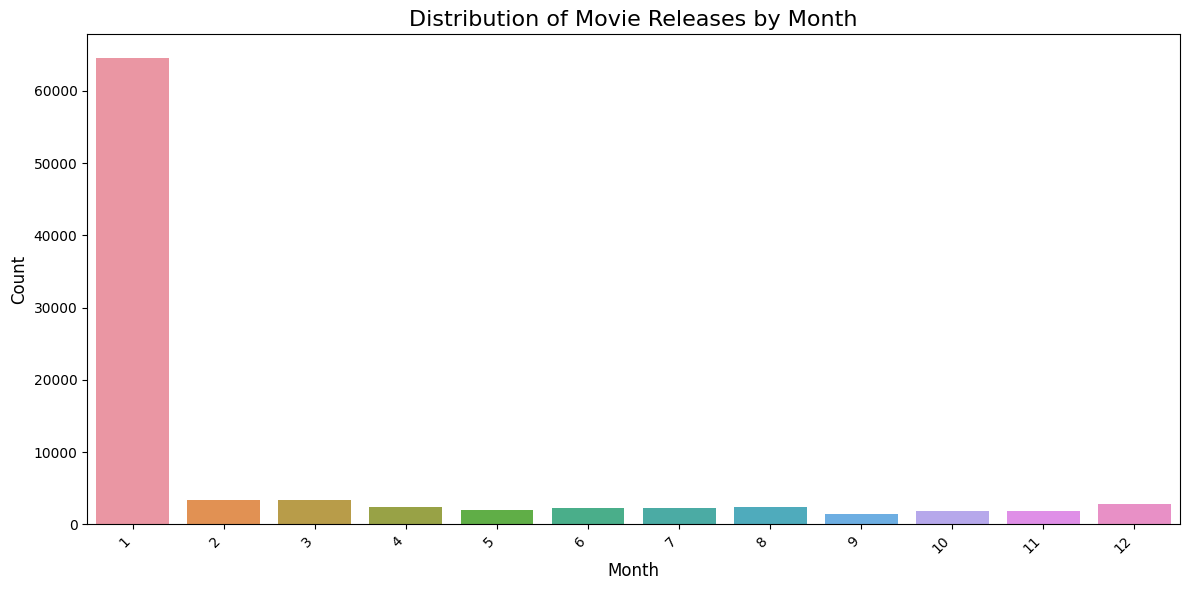

In [22]:
# distribution by release month
plot_count_distribution(train_df, 'release_month', 'Distribution of Movie Releases by Month', 'Month', order=months_order)

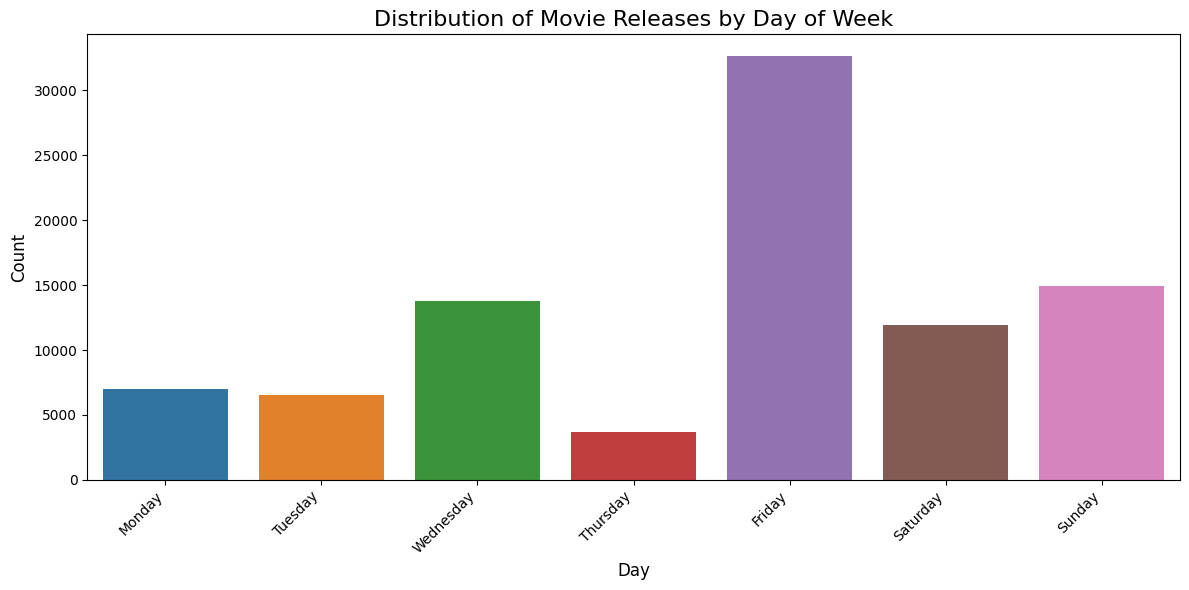

In [23]:
# distribution by release day of week
plot_count_distribution(train_df, 'release_day', 'Distribution of Movie Releases by Day of Week', 'Day', order=days_order)

### Genre EDA

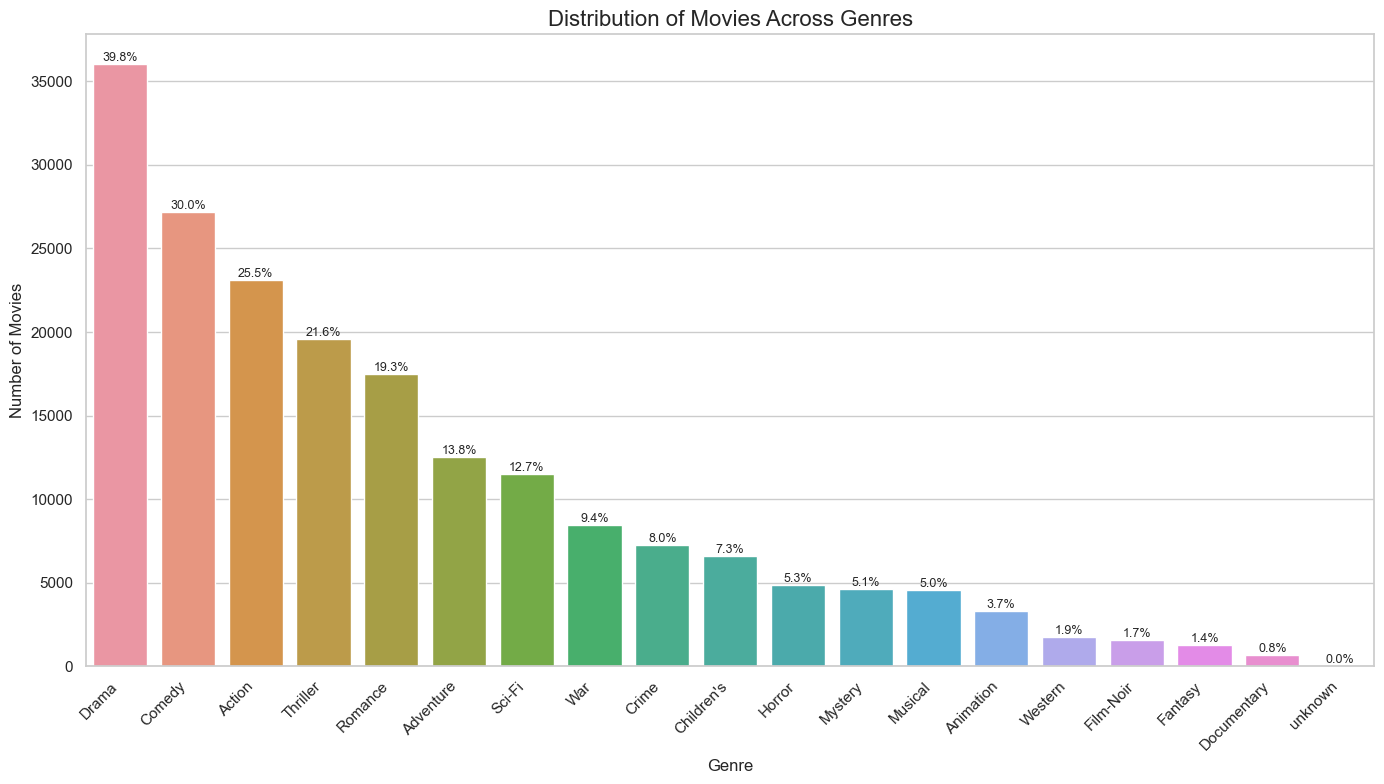

In [24]:
# countplots of each genre
genre_columns = [
    'unknown', 'Action', 'Adventure', 'Animation', "Children's",
    'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
    'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
    'Sci-Fi', 'Thriller', 'War', 'Western'
]

# 'combine' the genre columns into a single column
melted_df = pd.melt(train_df[genre_columns], var_name='Genre', value_name='Value')
melted_df = melted_df[melted_df['Value'] == 1]  # Keep only the rows where the genre is present

# calculate the total number of movies
total_movies = len(train_df)

# create plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
ax = sns.countplot(x='Genre', data=melted_df, order=melted_df['Genre'].value_counts().index)

plt.title('Distribution of Movies Across Genres', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45, ha='right')

# add % of genre
for i, p in enumerate(ax.patches):
    count = p.get_height()
    percentage = (count / total_movies) * 100
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()


As we can see, there are 0 unknown columns, and we can probably drop it.

In [25]:
genre_columns.remove('unknown')

In [26]:
genre_ratings = train_df.melt(id_vars=['user_id', 'age_group', 'gender'], value_vars=genre_columns, 
                              var_name='genre', value_name='is_genre')
genre_ratings = genre_ratings[genre_ratings['is_genre'] == 1]

  age_group gender       genre  count  proportion
0       <18      F      Action    375   10.717348
1       <18      F   Adventure    252    7.202058
2       <18      F   Animation     99    2.829380
3       <18      F  Children's    246    7.030580
4       <18      F      Comedy    513   14.661332


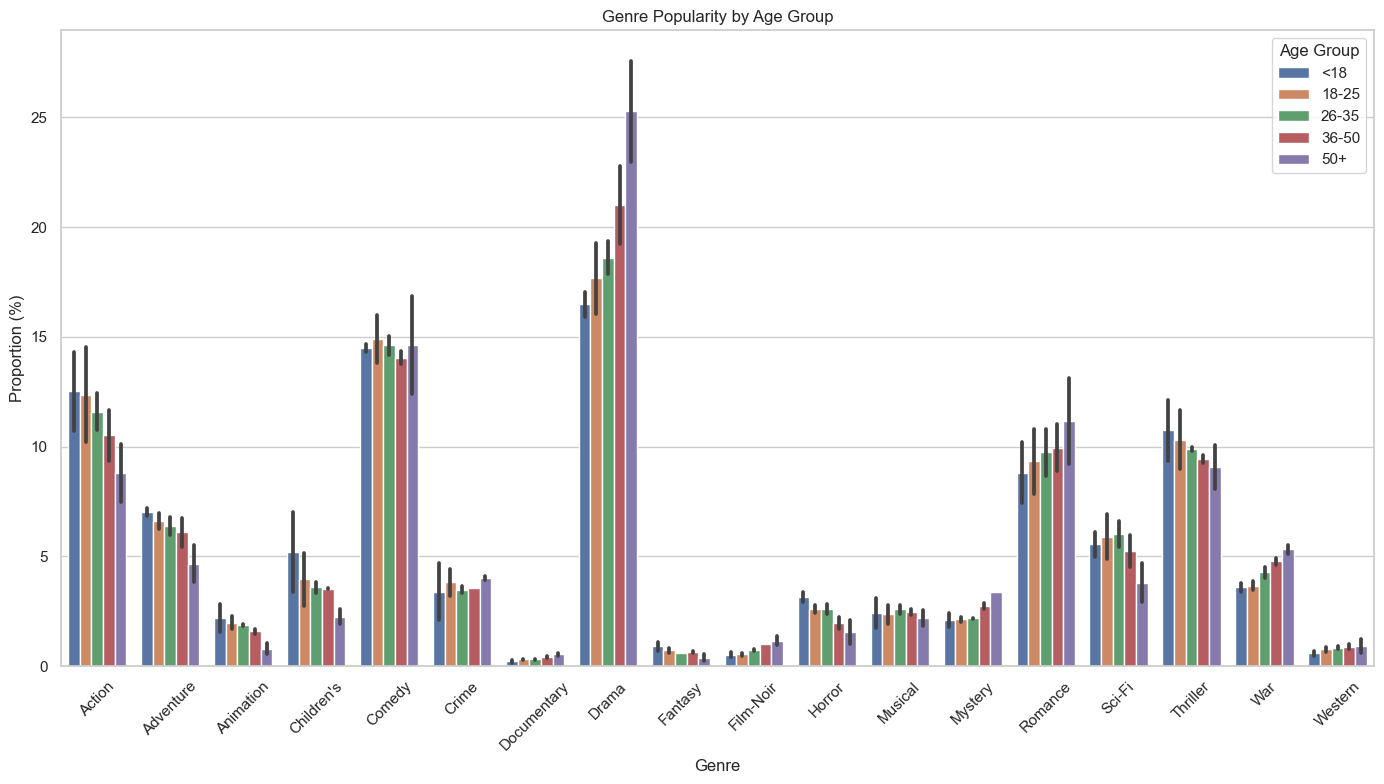

In [27]:
genre_popularity = genre_ratings.groupby(['age_group', 'gender', 'genre']).size().reset_index(name='count')

age_group_totals = genre_popularity.groupby(['age_group', 'gender'])['count'].transform('sum')
genre_popularity['proportion'] = genre_popularity['count'] / age_group_totals * 100  # scale

print(genre_popularity.head())

# genre popularity by age group
plt.figure(figsize=(14, 8))
sns.barplot(data=genre_popularity, x='genre', y='proportion', hue='age_group')
plt.title('Genre Popularity by Age Group')
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Proportion (%)')
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

  age_group gender       genre  count  proportion
0       <18      F      Action    375   10.717348
1       <18      F   Adventure    252    7.202058
2       <18      F   Animation     99    2.829380
3       <18      F  Children's    246    7.030580
4       <18      F      Comedy    513   14.661332


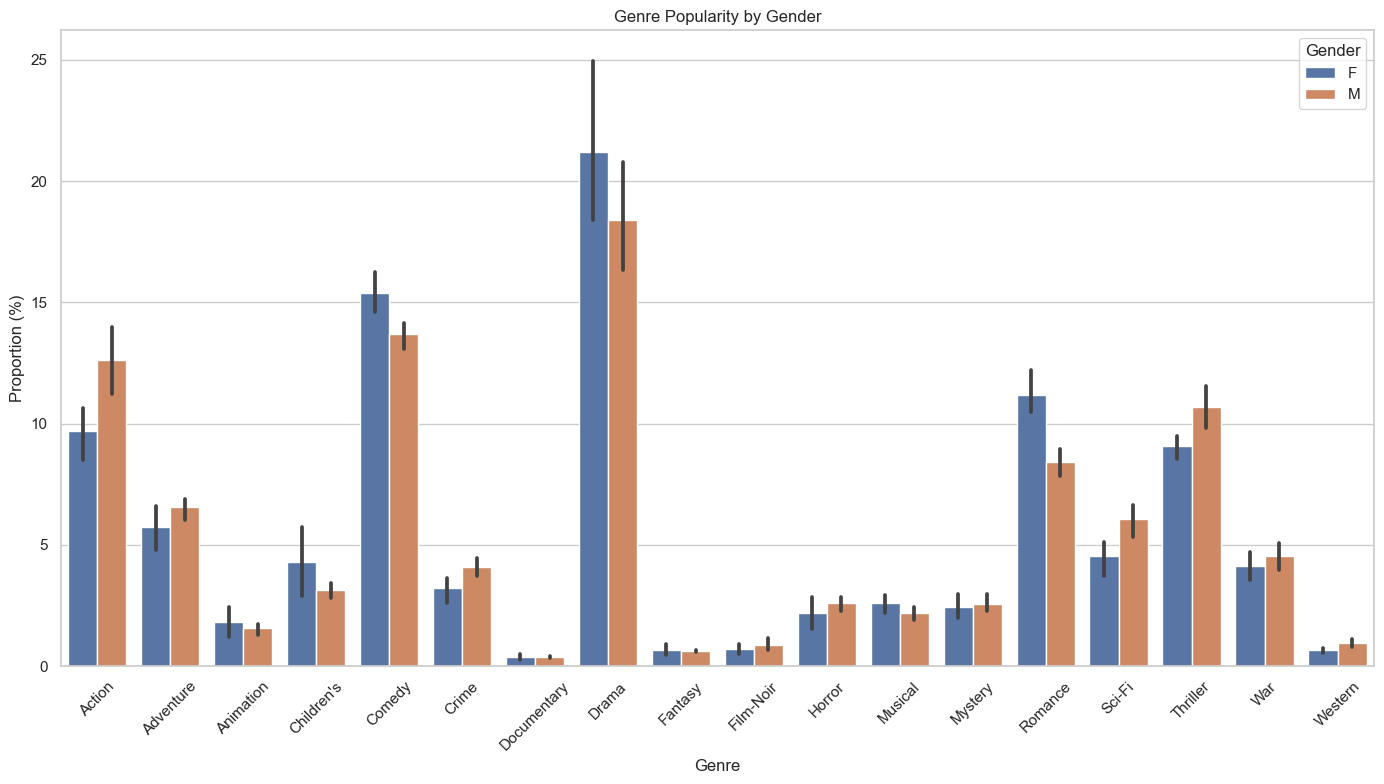

In [28]:
gender_totals = genre_popularity.groupby(['gender', 'age_group'])['count'].transform('sum')
genre_popularity['proportion'] = genre_popularity['count'] / gender_totals * 100  # scale

print(genre_popularity.head())

# genre popularity by gender
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.barplot(data=genre_popularity, x='genre', y='proportion', hue='gender')
plt.title('Genre Popularity by Gender')
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Proportion (%)')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


By using proportions, we observe which genre is most popular amongst each age group and gender.

### Preprocessing

In [29]:
train_df = train_df.drop(columns=['video_release_date', 'unknown'])
test_df = test_df.drop(columns=['video_release_date', 'unknown'])

In [30]:
print(train_df.shape)
print(test_df.shape)

(90570, 39)
(9430, 39)


In [31]:
train_df.to_csv("data/train_df.csv", index=False)
test_df.to_csv("data/test_df.csv", index=False)